# info

This script will generate a heatmap of hypoteses A, B and E.

This is due to the following contrasts:
* Hypothesis A: laminar over static
* Hypothesis B is oscillatory over laminar
* Hypothesis C i osicllatory Pi over laminar Pi
* Hypothesis D is laminar Pi over laminar no Pi
* Hypothesis E is oscillatory Pi over oscillatory no Pi

In [1]:
import os, pandas, numpy, seaborn
import scipy, scipy.stats

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(16, 9)})

# 0. user-defined variables

In [3]:
DEG_called_folder = '/Users/adrian/gd15/tmp/hegoi_tempo/sleuth/'
expression_file = '/Users/adrian/gd15/tmp/hegoi_tempo/DESeq2_TPM_values.tsv'
metadata_file = '/Users/adrian/gd15/tmp/hegoi_tempo/metadata/hegoi metadata - hypotheses formatted for filter.tsv'

In [4]:
DEG_called_folder = '/home/adrian/projects/hegoi/results/subsamples/sleuth/'
expression_file = '/home/adrian/projects/hegoi/results/tpm/DESeq2_TPM_values.tsv'
metadata_file = '/home/adrian/projects/hegoi/metadata/hegoi metadata - hypotheses formatted for filter.tsv'

In [5]:
working_hypotheses = ['A', 'B', 'E']

In [6]:
enrichment_folder = '/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/'

# 1. read data

## 1.1. read DEGs

In [7]:
file_names = os.listdir(DEG_called_folder)
file_names.remove('messages.txt')
file_names.sort()

degs = {}
for file_name in file_names:
    label = file_name.split('.csv')[0]
    df = pandas.read_csv(DEG_called_folder+file_name, index_col='target_id')
    ensembls = df.index.to_list()
    degs[label] = ensembls

## 1.2. read expression

In [8]:
expression = pandas.read_csv(expression_file, sep='\t', index_col=0)
print(expression.shape)
expression.head()

(40320, 26)


,Lam153,Lami154,Lami46,Lami94,LamiP109,LamiP153,LamiP154,LamiP176,LamiPi46,LamiPi94,...,OsciP154,OsciP175,OsciP178,OsciPi46,Stat109,Stat153,Stat154,Stat176,Stat46,Stat94
ENSG00000000003,24.240953,20.242011,22.919919,15.438227,18.098457,29.000777,14.784503,11.903633,26.217884,18.455471,...,38.756393,15.976121,21.649331,28.426877,29.688663,29.207002,28.989493,28.832380,34.600089,27.971771
ENSG00000000005,0.062960,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013958,0.000000,0.139231
ENSG00000000419,59.982918,62.984443,120.871295,138.059565,115.707396,84.892000,172.643218,147.901176,145.183145,135.750959,...,98.473591,161.024012,86.023654,115.321222,64.464680,81.686544,84.388415,88.740844,81.992995,97.987628
ENSG00000000457,4.680221,3.684855,1.989328,3.244174,4.417648,2.189278,6.217483,3.998143,4.786793,2.949599,...,3.012943,1.024624,2.255165,2.967113,1.825466,2.371161,3.513856,2.617785,2.546863,2.668982
ENSG00000000460,1.982690,1.344508,1.422365,1.667403,0.570064,2.856698,0.416009,0.000000,1.310974,1.812507,...,5.510741,3.805323,1.489214,0.957885,4.467578,5.425887,7.680067,4.002537,3.650609,4.056977


## 1.3. read metadata

In [9]:
metadata = pandas.read_csv(metadata_file, sep='\t')
metadata = metadata[(metadata['hypothesis'] == 'hypothesis_A') | (metadata['hypothesis'] == 'hypothesis_B') | (metadata['hypothesis'] == 'hypothesis_E')]
metadata

,hypothesis,patient,sampleA,sampleB
0,hypothesis_A,46,Stat46,Lami46
1,hypothesis_A,153,Stat153,Lam153
2,hypothesis_A,154,Stat154,Lami154
3,hypothesis_A,94,Stat94,Lami94
4,hypothesis_B,46,Lami46,Osci46
5,hypothesis_B,153,Lam153,Osci153
6,hypothesis_B,154,Lami154,Osci154
15,hypothesis_E,46,Osci46,OsciPi46
16,hypothesis_E,109,Osci109,OsciP109
17,hypothesis_E,153,Osci153,OsciP153


In [10]:
samples = []
for working_hypothesis in working_hypotheses:
    label = 'hypothesis_{}'.format(working_hypothesis)
    
    sub = metadata[metadata['hypothesis'] == label]
    
    samplesA = sub['sampleA'].to_list()
    samplesB = sub['sampleB'].to_list()
    both = samplesA + samplesB
    
    for element in both:
        samples.append(element)
    
working_samples = list(set(samples))
print(working_samples)

['Stat153', 'Osci153', 'Stat46', 'Lami94', 'Osci109', 'OsciP154', 'Lami154', 'Lam153', 'OsciP153', 'Osci46', 'Osci154', 'OsciPi46', 'OsciP109', 'Stat154', 'Stat94', 'Lami46']


# 2. select response genes

Response genes should pass the log2FC > 1 and have P < 0.05 for at least n-1 samples.

In [11]:
def response_gene_finder(ensembl, hypo, patient):
    
    success = True; trend = None
    
    # filter 1 --- called by sleuth
    label = '{}_{}'.format(hypo_label, patient)
    if ensembl not in degs[label]:
        success = False
        
    # filter 2 --- abs log2FC < 1 and max. expr. < 2 
    if success == True:
        labela = metadata[(metadata['hypothesis'] == hypo_label) & (metadata['patient'] == patient)]['sampleA'].values[0]
        labelb = metadata[(metadata['hypothesis'] == hypo_label) & (metadata['patient'] == patient)]['sampleB'].values[0]
        expr_num = expression.loc[ensembl, labelb]; expr_den = expression.loc[ensembl, labela]
        log2FC = numpy.log2((expr_num+1)/(expr_den+1))
        abs_log2FC = numpy.abs(log2FC)
        top = numpy.max([expr_num, expr_den])
        if abs_log2FC < 1 or top < 2:
            success = False
    
    # not a filter --- assign a trend if success. necessary for consistency across patients
    if success == True:
        if log2FC > 0:
            trend = 'up'
        elif log2FC < 0:
            trend = 'down'
            
    return success, trend

In [12]:
%%time
all_response_genes = []
for hypo in working_hypotheses:
    print('working with hypothesis {}'.format(hypo))
    hypo_label = 'hypothesis_{}'.format(hypo)
    
    sub = metadata[metadata['hypothesis'] == hypo_label]
    patients = sub['patient']
    patients = [46, 153, 154]
    
    response_genes = []; up = []; down = []
    ### iterate each gene
    print('about to iterate genes')
    for ensembl in expression.index:
        
        ### iterate over patients to see if filters are passed in n - 1 patients
        successes = []; trends = []
        for patient in patients:
            success, trend = response_gene_finder(ensembl, hypo, patient)
            successes.append(success); trends.append(trend)
        if sum(successes) >= len(patients):
            if trends.count('up') >= len(patients):
                up.append(ensembl)
                response_genes.append(ensembl)
            if trends.count('down') >= len(patients):
                down.append(ensembl)
                response_genes.append(ensembl)
    
    # number of genes identified
    print('{} response genes detected'.format(len(response_genes)))
    print('up and down regulated genes: {} {}'.format(len(up), len(down)))
    all_response_genes.append(set(response_genes))
    
    # store for functional analysis
    storage = '{}hypo_{}_{}'.format(enrichment_folder, hypo, 'up.tsv')
    print(storage, len(up))
    with open(storage, 'w') as f:
        for element in up:
            f.write('{}\n'.format(element))
    f.close()
    
    storage = '{}hypo_{}_{}'.format(enrichment_folder, hypo, 'down.tsv')
    print(storage, len(down))
    with open(storage, 'w') as f:
        for element in down:
            f.write('{}\n'.format(element))
    f.close()
    
    print()

# define the set of responding genes over all hypotheses
all_response_genes = list(set().union(*all_response_genes))
print('overall, {} response genes detected'.format(len(all_response_genes)))

working with hypothesis A
about to iterate genes
419 response genes detected
up and down regulated genes: 64 355
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_A_up.tsv 64
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_A_down.tsv 355

working with hypothesis B
about to iterate genes
129 response genes detected
up and down regulated genes: 98 31
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_B_up.tsv 98
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_B_down.tsv 31

working with hypothesis E
about to iterate genes
47 response genes detected
up and down regulated genes: 3 44
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_E_up.tsv 3
/home/adrian/projects/hegoi/results/functional_enrichment_sleuth/hypo_E_down.tsv 44

overall, 502 response genes detected
CPU times: user 1min 35s, sys: 438 ms, total: 1min 35s
Wall time: 1min 35s


# 3. build the heatmap

Patients 94 and 109 are excluded to calculate a consistent z-score

In [13]:
strict_metadata = metadata.drop(index=[3, 16])
strict_metadata

,hypothesis,patient,sampleA,sampleB
0,hypothesis_A,46,Stat46,Lami46
1,hypothesis_A,153,Stat153,Lam153
2,hypothesis_A,154,Stat154,Lami154
4,hypothesis_B,46,Lami46,Osci46
5,hypothesis_B,153,Lam153,Osci153
6,hypothesis_B,154,Lami154,Osci154
15,hypothesis_E,46,Osci46,OsciPi46
17,hypothesis_E,153,Osci153,OsciP153
18,hypothesis_E,154,Osci154,OsciP154


In [14]:
a = set(strict_metadata['sampleA'])
b = set(strict_metadata['sampleB'])
c = list(a.union(b))
c.sort()
print(c, len(c))

['Lam153', 'Lami154', 'Lami46', 'Osci153', 'Osci154', 'Osci46', 'OsciP153', 'OsciP154', 'OsciPi46', 'Stat153', 'Stat154', 'Stat46'] 12


In [15]:
response_expression = expression.loc[all_response_genes, c]

print(response_expression.shape)
response_expression.head()

(502, 12)


,Lam153,Lami154,Lami46,Osci153,Osci154,Osci46,OsciP153,OsciP154,OsciPi46,Stat153,Stat154,Stat46
ENSG00000072571,0.759270,1.035108,2.513639,3.496979,3.222098,2.808839,0.802889,3.092185,1.634887,12.662476,15.603060,9.810860
ENSG00000196628,25.191420,24.572250,15.269910,56.054160,84.275570,56.980990,27.198490,34.721220,31.423330,42.757600,65.864780,42.936410
ENSG00000155962,28.515080,38.746740,7.765990,9.923585,10.078490,1.994898,4.341117,5.755759,3.456739,6.588230,9.636118,2.951615
ENSG00000005187,2.653513,3.015988,1.134474,11.672786,8.765378,2.268588,1.961936,2.547482,1.686217,11.781282,26.902892,3.766690
ENSG00000089685,0.394067,0.995570,1.329406,6.384052,3.857296,3.592672,2.937911,8.941979,2.119328,34.057999,26.199910,14.513066


In [16]:
# compute z-score for vmin and vmax purposes
zscore_df = scipy.stats.zscore(response_expression, axis=1)

top = numpy.max(numpy.max(zscore_df, axis=1))
bottom = numpy.min(numpy.min(zscore_df, axis=1))

print(top, bottom)
b = 2.5

colors = [(0, "blue"), (0.5-(1/(b*4)), "white"), (0.5+(1/(b*4)), "white"), (1, "red")]
bwwr = matplotlib.colors.LinearSegmentedColormap.from_list("bwwr", colors)

3.2897901546682338 -2.012066764619843


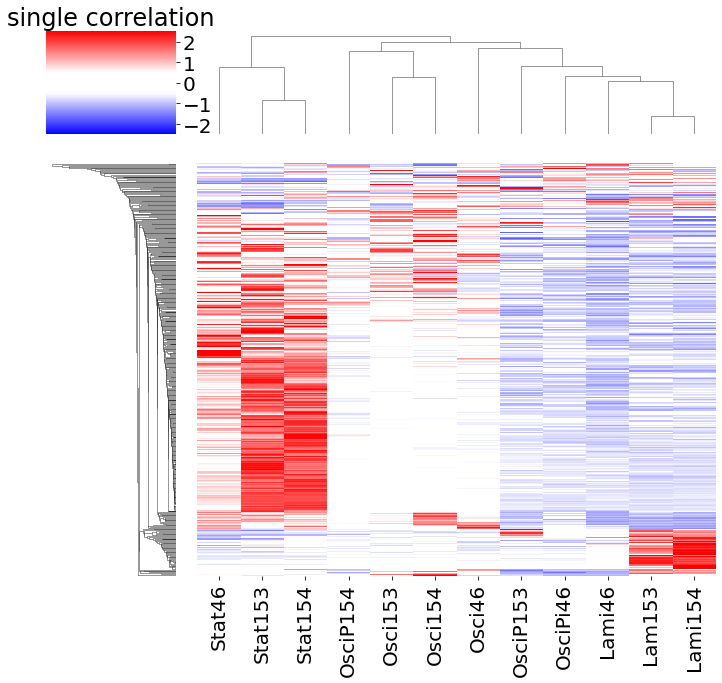

In [17]:
seaborn.clustermap(response_expression, 
                   cmap=bwwr, 
                   z_score=0, 
                   metric='correlation', 
                   method='single', 
                   yticklabels=False, 
                   vmin=-b, vmax=b, 
                   cbar_kws={"ticks":[-2, -1, 0, 1, 2]}
                  )

matplotlib.pyplot.title('{} {}'.format('single', 'correlation'))
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()